In [1]:
import os
os.chdir(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\timeseires')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [5]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [7]:
def CNN():
    input_data = Input(shape=(time_steps, num_features))
    x1 = Conv1D(16, 2, activation="relu")(input_data)
    x2 = Conv1D(16, 2, activation="relu")(x1)
    flatten = Flatten()(x2)
    output_data = Dense(1)(flatten)
    model = Model(input_data, output_data)
    return model

In [9]:
model1 = CNN()
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 24, 21)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 23, 16)              │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 22, 16)              │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,569 (6.13 KB)

 Trainable params: 1,569 (6.13 KB)

 Non-trainable params: 0 (0.00 B)

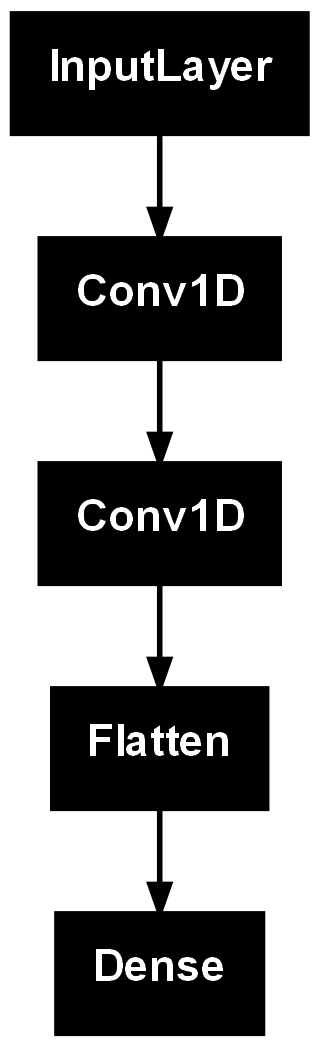

In [11]:
tensorflow.keras.utils.plot_model(model1 )

In [13]:
checkpoints = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08'
#FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
#JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [35]:
import os
from keras.callbacks import ModelCheckpoint

# Define necessary paths and variables
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

FIG_PATH = os.path.sep.join([output_dir, "training_plot.png"])
JSON_PATH = os.path.sep.join([output_dir, "training_history.json"])
checkpoints = os.path.join(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08', 'best_model.h5')
start_epoch = 0  # Change this if you're resuming from a checkpoint

# Construct the callback to save only the best model to disk based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                                   monitor="val_loss",
                                   save_best_only=True, 
                                   verbose=1)

# Make sure the TrainingMonitor class is implemented/imported properly
TrainingMonitor1 = TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# Construct the set of callbacks
callbacks = [EpochCheckpoint1, TrainingMonitor1]


In [37]:
from keras.models import load_model
from keras.optimizers import Adam
import keras.backend as K

# Define your model path
model_path =r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5'

# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if not os.path.exists(model_path):  # If the model file doesn't exist, start fresh
    print("[INFO] compiling model...")
    model = CNN()  # define your CNN() model earlier
    opt = Adam(1e-3)
    model.compile(loss='mae', optimizer=opt, metrics=["mae", "mape"])

# otherwise, load the checkpoint from disk
else:
    print(f"[INFO] loading model from {model_path}...")
    model = load_model(model_path)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))


[INFO] compiling model...


In [39]:
import os
path_dataset =r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

D:\anconda\envs\MLLab\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [41]:
time_steps=24
num_features=21

In [43]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.6816089153289795 sec


In [45]:
epochs = 30
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/30
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0711 - mae: 0.0711 - mape: 1439.4285
Epoch 1: val_loss improved from inf to 0.02132, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0711 - mae: 0.0711 - mape: 1439.4043 - val_loss: 0.0213 - val_mae: 0.0213 - val_mape: 9.5158
Epoch 2/30
2645/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0194 - mae: 0.0194 - mape: 54.6958
Epoch 2: val_loss improved from 0.02132 to 0.01937, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0194 - mae: 0.0194 - mape: 55.5384 - val_loss: 0.0194 - val_mae: 0.0194 - val_mape: 10.3515
Epoch 3/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - mae: 0.0146 - mape: 113.8555
Epoch 3: val_loss improved from 0.01937 to 0.01130, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0146 - mae: 0.0146 - mape: 114.1994 - val_loss: 0.0113 - val_mae: 0.0113 - val_mape: 6.6425
Epoch 4/30
2643/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - mae: 0.0123 - mape: 1226.9264
Epoch 4: val_loss improved from 0.01130 to 0.01100, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0123 - mae: 0.0123 - mape: 1223.6550 - val_loss: 0.0110 - val_mae: 0.0110 - val_mape: 7.0305
Epoch 5/30
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.0113 - mape: 109.5981
Epoch 5: val_loss improved from 0.01100 to 0.01074, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0113 - mae: 0.0113 - mape: 110.5726 - val_loss: 0.0107 - val_mae: 0.0107 - val_mape: 6.6612
Epoch 6/30
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - mae: 0.0106 - mape: 4.2362
Epoch 6: val_loss improved from 0.01074 to 0.01023, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.0106 - mae: 0.0106 - mape: 4.4453 - val_loss: 0.0102 - val_mae: 0.0102 - val_mape: 6.5769
Epoch 7/30
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - mae: 0.0104 - mape: 659.5516
Epoch 7: val_loss improved from 0.01023 to 0.00936, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0104 - mae: 0.0104 - mape: 659.2668 - val_loss: 0.0094 - val_mae: 0.0094 - val_mape: 6.1274
Epoch 8/30
2645/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - mae: 0.0100 - mape: 178.7574
Epoch 8: val_loss did not improve from 0.00936
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0100 - mae: 0.0100 - mape: 180.4832 - val_loss: 0.0109 - val_mae: 0.0109 - val_mape: 6.7348
Epoch 9/30
2638/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - mae: 0.0100 - mape: 1054.0747
Epoch 9: val_loss did not improve from 0.00936
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0100 - mae: 0.0100 - mape: 1052.2344 - val_loss: 0.0100 - val_mae: 0.0100 - val_mape: 6.4085
Epoch 10/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096 - mae: 0.0096 - mape: 505.8438
Epoch 10: val_loss improved from 0.00936 to 0.00924, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0096 - mae: 0.0096 - mape: 505.7461 - val_loss: 0.0092 - val_mae: 0.0092 - val_mape: 6.1405
Epoch 11/30
2638/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - mae: 0.0092 - mape: 476.8067
Epoch 11: val_loss improved from 0.00924 to 0.00885, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0092 - mae: 0.0092 - mape: 477.8629 - val_loss: 0.0089 - val_mae: 0.0089 - val_mape: 5.7020
Epoch 12/30
2639/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - mae: 0.0093 - mape: 972.6777
Epoch 12: val_loss did not improve from 0.00885
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0093 - mae: 0.0093 - mape: 969.7434 - val_loss: 0.0095 - val_mae: 0.0095 - val_mape: 5.9203
Epoch 13/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - mae: 0.0091 - mape: 1157.0941
Epoch 13: val_loss did not improve from 0.00885
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0091 - mae: 0.0091 - mape: 1156.5297 - val_loss: 0.0110 - val_mae: 0.0110 - val_mape: 6.2811
Epoch 14/30
2640/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - mae: 0.0094 - mape: 701.4592
Epoch 14: val_loss improved from 0.00885 to 0.00878, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0094 - mae: 0.0094 - mape: 701.1406 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 6.0266
Epoch 15/30
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - mae: 0.0087 - mape: 135.6386
Epoch 15: val_loss improved from 0.00878 to 0.00794, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0087 - mae: 0.0087 - mape: 135.9092 - val_loss: 0.0079 - val_mae: 0.0079 - val_mape: 4.9870
Epoch 16/30
2646/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - mae: 0.0089 - mape: 812.3580
Epoch 16: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0089 - mae: 0.0089 - mape: 811.5092 - val_loss: 0.0095 - val_mae: 0.0095 - val_mape: 6.3839
Epoch 17/30
2641/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - mae: 0.0089 - mape: 369.1987
Epoch 17: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0089 - mae: 0.0089 - mape: 370.3686 - val_loss: 0.0086 - val_mae: 0.0086 - val_mape: 5.4752
Epoch 18/30
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - mae: 0.0090 - mape: 187.4643
Epoch 18: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0090 - mae: 0.0090 - mape: 187.9369 - val_loss: 0.0082 - val_

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0084 - mae: 0.0084 - mape: 201.1841 - val_loss: 0.0079 - val_mae: 0.0079 - val_mape: 5.2391
Epoch 24/30
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0086 - mae: 0.0086 - mape: 568.5270
Epoch 24: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 0.0086 - mae: 0.0086 - mape: 568.5427 - val_loss: 0.0104 - val_mae: 0.0104 - val_mape: 6.7895
Epoch 25/30
2647/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mae: 0.0085 - mape: 232.9584
Epoch 25: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0085 - mae: 0.0085 - mape: 234.1710 - val_loss: 0.0084 - val_mae: 0.0084 - val_mape: 5.7149
Epoch 26/30
2640/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - mae: 0.0084 - mape: 89.8815
Epoch 26: val_loss did not improve from 0.00794
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0084 - mae: 0.0084 - mape: 93.0614 - val_loss: 0.0094 - val_ma

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0085 - mae: 0.0085 - mape: 1984.8944 - val_loss: 0.0076 - val_mae: 0.0076 - val_mape: 5.5033
Epoch 28/30
2644/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - mae: 0.0083 - mape: 1162.6803
Epoch 28: val_loss improved from 0.00760 to 0.00746, saving model to E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0083 - mae: 0.0083 - mape: 1160.9430 - val_loss: 0.0075 - val_mae: 0.0075 - val_mape: 5.4379
Epoch 29/30
2639/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - mae: 0.0083 - mape: 840.8356
Epoch 29: val_loss did not improve from 0.00746
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0083 - mae: 0.0083 - mape: 839.7014 - val_loss: 0.0081 - val_mae: 0.0081 - val_mape: 5.2666
Epoch 30/30
2642/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - mae: 0.0085 - mape: 1053.2216
Epoch 30: val_loss did not improve from 0.00746
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0085 - mae: 0.0085 - mape: 1051.5278 - val_loss: 0.0085 - val_mae: 0.0085 - val_mape: 5.3444


In [47]:
model = load_model(r'E:\USAMA\Eight semester\Machine learning\Lab Data\ML Lab Spring 25\lab 08\best_model.h5',
                   custom_objects={'mae': mean_absolute_error})


y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Absolute Error (MAE): 119.07
Median Absolute Error (MedAE): 94.46
Mean Squared Error (MSE): 25109.65
Root Mean Squared Error (RMSE): 158.46
Mean Absolute Percentage Error (MAPE): 0.83 %
Median Absolute Percentage Error (MDAPE): 0.64 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [16]:
checkpoints = r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E1-cp-0058-loss0.01.h5'
start_epoch= 58

In [17]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E1-cp-0058-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [18]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2651/2653 [============================>.] - ETA: 0s - loss: 0.0064 - mae: 0.0064 - mape: 711.7792
Epoch 1: val_loss improved from inf to 0.00659, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 36s 13ms/step - loss: 0.0064 - mae: 0.0064 - mape: 711.3610 - val_loss: 0.0066 - val_mae: 0.0066 - val_mape: 4.3460
Epoch 2/10
2644/2653 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 578.1265
Epoch 2: val_loss improved from 0.00659 to 0.00642, saving model to C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 10s 4ms/step - loss: 0.0063 - mae: 0.0063 - mape: 576.2668 - val_loss: 0.0064 - val_mae: 0.0064 - val_mape: 4.2309
Epoch 3/10
2646/2653 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 551.6437
Epoch 3: val_loss did not improve from 0.0064

In [19]:

model = load_model(r'C:\Users\Administrator\Downloads\ML Lab\checkpoint\ML Lab\lab8\E2-cp-0008-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 1s 2ms/step
Mean Absolute Error (MAE): 103.3
Median Absolute Error (MedAE): 82.18
Mean Squared Error (MSE): 18772.44
Root Mean Squared Error (RMSE): 137.01
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.57 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


# lab report 

## Lab 1